In [4]:
import warnings
import contextlib

import requests
from urllib3.exceptions import InsecureRequestWarning


old_merge_environment_settings = requests.Session.merge_environment_settings

@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass

In [71]:
import pandas as pd, numpy as np
import quandl, math
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [79]:
with no_ssl_verification():
    df = quandl.get("WIKI/GOOGL")

df[ ['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',] ] [0:10]

df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_Change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close','HL_PCT','PCT_Change','Volume']]

forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))

df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [87]:
# clf = svm.SVR(gamma='auto')
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

0.9789345937252663


In [88]:
forecast_set = clf.predict(X_lately)

print(forecast_set, confidence, forecast_out)

[1100.70512035 1071.10635274 1017.83210532 1059.64203971 1071.77800289
 1072.0454023  1090.6407156  1109.89552099 1112.98062346 1120.96953361
 1130.13117521 1127.74948762 1147.27114569 1162.88305404 1134.39140552
 1120.66371994 1086.37937075 1101.73930217 1112.69809248 1119.79089888
 1133.55336461 1148.25018896 1179.68628865 1184.07376076 1155.83501836
 1167.00791219 1168.82823663 1151.61888805 1117.08557439 1113.56674621
 1111.25372201 1068.48360061 1040.64990257 1071.68605076 1019.41781939] 0.9789345937252663 35


In [82]:
for k in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = svm.SVR(kernel=k, gamma='auto')
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k, confidence)

linear 0.976919028964604
poly 0.5713780699094825
rbf 0.7784652776399514
sigmoid 0.8821374311475784


In [90]:
import datetime, matplotlib.pyplot as plt
from matplotlib import style

In [92]:
style.use('ggplot')
df['Forecast'] = np.nan

In [94]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [95]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

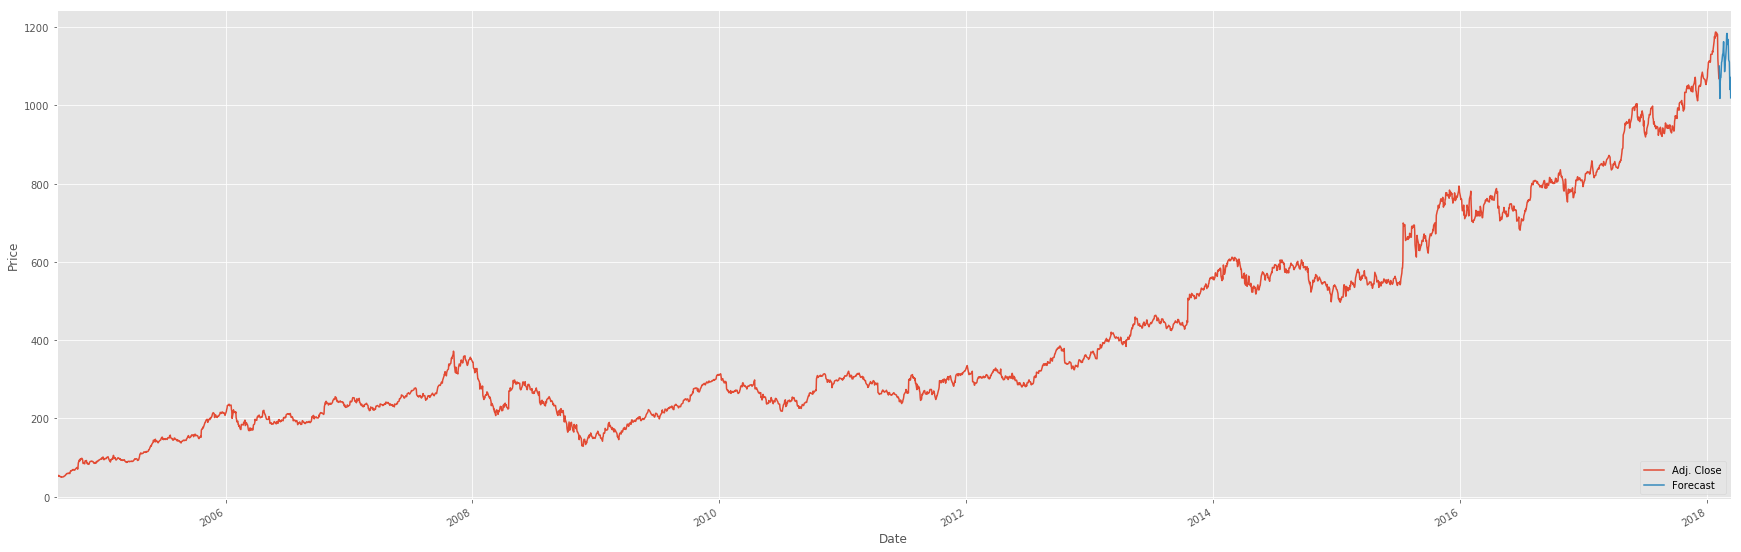

In [108]:
plt.figure(figsize=(30,10))
df['Adj. Close'].plot()
df['Forecast'].plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

In [109]:
import pickle